In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Generate data

In [2]:
class DataModule():
    def __init__(self, num_observatiosn=2000, batch_size=128, num_workers=2, is_train=True):
        self.N = num_observatiosn
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.is_train = is_train

    def generate_orgin(self, batch_size: int) -> torch.Tensor:
        """Generate original data."""
        raise NotImplementedError

    def _generate_data(self, iterations=3):
        self.origin = self.generate_orgin(self.N)
        d = self.origin.clone()
        w_size = d.shape[1]
        for i in range(iterations):
            W = np.random.uniform(-1, 1, size=(w_size, w_size))
            d = torch.tanh(d @ W)
        self.data = d.to(torch.float32)

    def get_dataloader(self, iterations=3):
        self._generate_data(iterations=iterations)
        return DataLoader((self.data, self.generate_orgin(self.N)), batch_size=self.batch_size, \
                          num_workers=self.num_workers, shuffle=self.is_train)
    
    def show_distribution(self, data: torch.Tensor, nrows: int, ncols: int):
        assert data.shape[1] == nrows*ncols, "The number of subplots does not match the number of data."
        fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
        axs = axs.reshape((nrows, ncols))
        for r in range(nrows):
            for c in range(ncols):
                idx = r * ncols + c
                sns.histplot(data[:, idx], ax=axs[r, c])


class Data_dim2(DataModule):
    def __init__(self, num_observatiosn=2000, batch_size=128, num_workers=2, is_train=True):
        super().__init__(num_observatiosn, batch_size, num_workers, is_train)
    
    def generate_orgin(self, batch_size) -> torch.Tensor:
        size = (batch_size, 1)
        d1 = np.random.uniform(-1, 1, size)
        d2 = np.random.exponential(1, size)
        origin = torch.tensor(np.concatenate([d1, d2], axis=1), dtype=torch.float32)
        return origin

### MMD
Can consider use multiple kernels in the MMD-GAN

In [3]:
def rbf_kernel(X, Y, gamma):
    """
    Calculate the RBF kernel of the given data X and Y
    
    Args
    ----
    X, Y: torch.Tensor
        The target data
    gamma: float
        Inverse of the bandwidth (1/sigma)
        
    Returns
    -------
    """
    assert X.shape[1] == Y.shape[1], "The data should have the same dimension."

    # Calculate the Euclidean distance between the every pair of data in X and Y
    K = ((X[: ,np.newaxis, :] - Y[np.newaxis, :, :])**2).sum(axis=2)
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    K *= -gamma 
    return torch.exp(K)

def mmd2(X, Y, kernel=rbf_kernel, gamma=10):
    K_xx, K_xy, K_yy = kernel(X, X, gamma), kernel(X, Y, gamma), kernel(Y, Y, gamma)
    n = X.shape[0]
    numerator = n * (n - 1)
    return K_xx.sum() / numerator - (2*K_xy.sum())  /numerator + K_yy.sum() / numerator

def mmd(X, Y, kernel=rbf_kernel, **kwargs):
    return mmd2(X, Y, kernel, **kwargs)**(0.5)

### Network

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, input_size),
        )
    
    def __getitem__(self, idx):
        return self.net[idx]
    
    def forward(self, X):
        return self.net(X)

def weight_init(m: nn.Module):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)

### Train

In [46]:
batch_size = 256
data = Data_dim2(num_observatiosn=2000, batch_size=batch_size)
train_loader = data.get_dataloader(3)

In [75]:
net = Encoder(input_size=data.data.shape[1]).to(device)
net.apply(weight_init)

Encoder(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=2, bias=True)
  )
)

In [84]:
betas = (0.9, 0.999)
lr = 5e-6
wd = 0
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [77]:
num_epochs = 100
loss = mmd
gamma = 10

In [78]:
def train(num_epochs, train_loader, device, loss, net, optimizer):
    loss_list = []
    for epoch in range(num_epochs):
        for X, y in train_loader:
            X, y = X.to(device=device), y.to(device=device)
            l = loss(net(X), net(y), gamma=gamma)
            l.backward()
            optimizer.step()
        
            loss_list.append(l.item())

        if (epoch + 1) % 10 == 0:
            print(f'[{epoch+1}/{num_epochs}] Loss: {loss_list[-1]}')
            
    sns.lineplot(data=loss_list)

[10/100] Loss: 0.056499965488910675
[20/100] Loss: 0.05326519533991814
[30/100] Loss: 0.050433214753866196
[40/100] Loss: 0.04804114252328873
[50/100] Loss: 0.046115443110466
[60/100] Loss: 0.044679734855890274
[70/100] Loss: 0.043741390109062195
[80/100] Loss: 0.043295569717884064
[90/100] Loss: 0.043313466012477875
[100/100] Loss: 0.04376659169793129


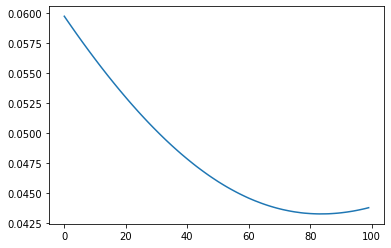

In [90]:
train(num_epochs, train_loader, device, loss, net, optimizer)

In [91]:
with torch.no_grad():
    y = net(data.data.to(device=device))
y

tensor([[-0.0470,  0.1285],
        [-0.0502,  0.1297],
        [-0.0512,  0.1288],
        ...,
        [-0.0483,  0.1300],
        [-0.0508,  0.1320],
        [-0.0473,  0.1289]], device='cuda:0')

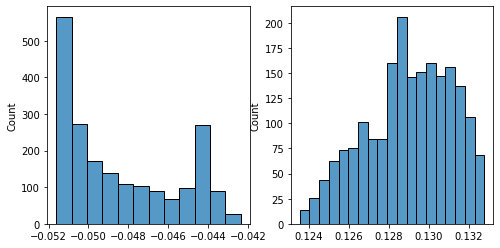

In [92]:
data.show_distribution(y.cpu(), 1, 2)

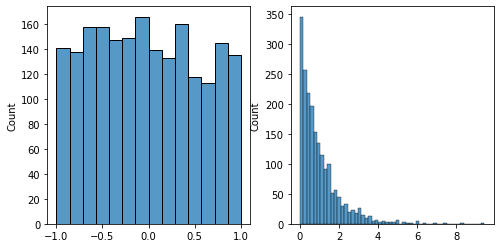

In [93]:
data.show_distribution(data.origin, 1, 2)

1. batch size
2. 试一下别的激活函数